In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?dl=0

--2021-07-13 11:46:19--  https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dtw18saps0231yn/BrainTumorData.zip [following]
--2021-07-13 11:46:19--  https://www.dropbox.com/s/raw/dtw18saps0231yn/BrainTumorData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4dc495a575d256715a007f662.dl.dropboxusercontent.com/cd/0/inline/BSOp2EKnoxE4cMWOAQxehLoAUkIDcFl1MA2um8QGF9RnWKJ6Ud9uLtzRngze5Vq4jcqRceOjrdmy59TGd8wbCi_3KIFyr_QFp2gcvqDsibNBpRKPBVqNxKRcmGlCIcVGnPNqlMy6b4HYh7q8A659f667/file# [following]
--2021-07-13 11:46:19--  https://ucc4dc495a575d256715a007f662.dl.dropboxusercontent.com/cd/0/inline/BSOp2EKnoxE4cMWOAQxehLoAUkIDcFl1MA2um8QGF9RnWKJ6Ud9uLtzRngze5Vq4jcq

In [3]:
# unzipp the data
!unzip BrainTumorData.zip?dl=0

Archive:  BrainTumorData.zip?dl=0
   creating: BrainTumorData/Brain Tumor Data Set/
   creating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tum

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import shutil
import glob
import cv2

In [5]:
import keras
from keras.layers import  Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input

In [6]:
root_dir = '/content/BrainTumorData/Brain Tumor Data Set'

number_of_images = {}

for dir in os.listdir(root_dir):
    number_of_images[dir] = len(os.listdir(os.path.join(root_dir, dir)))

number_of_images.items()

dict_items([('Healthey', 2087), ('Brain Tumor', 2513)])

In [7]:
def dataFolder(p, split):
    if not os.path.exists('./'+p):
        os.mkdir("./"+p)

        for dir in os.listdir(root_dir):
            os.makedirs('./'+p+'/'+ dir)

            for img in np.random.choice(a = os.listdir(os.path.join(root_dir, dir)), 
                                        size= (math.floor(split*number_of_images[dir])-5), 
                                        replace=False):
                O = os.path.join(root_dir,dir,img)
                D = os.path.join('./'+p,dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f" {p} folder exists")

In [8]:
dataFolder('train',0.7)

In [9]:
dataFolder('val',0.15)

In [10]:
dataFolder('test',0.15)

In [11]:
# output preproceessed images
# data ogmentation
def preprocessingImages1(path):
    image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, preprocessing_function= preprocess_input, horizontal_flip=True)
    
    image = image_data.flow_from_directory(directory= path, target_size= (224,224), batch_size = 32, class_mode= 'binary')

    return image

In [12]:
path = '/content/train'
train_data = preprocessingImages1(path)

Found 3209 images belonging to 2 classes.


In [13]:
# output preproceessed images
def preprocessingImages2(path):
    image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
    
    image = image_data.flow_from_directory(directory= path, target_size= (224,224), batch_size = 32, class_mode= 'binary')

    return image

In [14]:
path = '/content/test'
test_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [15]:
path = '/content/val'
val_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [16]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthey': 1}

# MOdel

In [17]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
X  = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)

model = Model(base_model.input, X)

In [20]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [21]:
model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [22]:
# early stopping and model checkpoints
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)

#model check point
mc = ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.h5', verbose=1, save_best_only=True)

cb = [es,mc]

In [23]:
hist = model.fit_generator(train_data, 
                           steps_per_epoch=10, 
                           epochs=30, 
                           validation_data=val_data, 
                           validation_steps=16, 
                           callbacks=cb )

Epoch 1/30
10/10 [==============================] - 57s 829ms/step - loss: 10.6362 - accuracy: 0.5347 - val_loss: 3.3074 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to ./bestmodel.h5
Epoch 2/30
10/10 [==============================] - 6s 621ms/step - loss: 2.4350 - accuracy: 0.7319 - val_loss: 0.9430 - val_accuracy: 0.8418

Epoch 00002: val_accuracy improved from 0.62500 to 0.84180, saving model to ./bestmodel.h5
Epoch 3/30
10/10 [==============================] - 6s 619ms/step - loss: 1.6107 - accuracy: 0.8159 - val_loss: 0.3970 - val_accuracy: 0.9258

Epoch 00003: val_accuracy improved from 0.84180 to 0.92578, saving model to ./bestmodel.h5
Epoch 4/30
10/10 [==============================] - 6s 617ms/step - loss: 0.7534 - accuracy: 0.8711 - val_loss: 0.8861 - val_accuracy: 0.8535

Epoch 00004: val_accuracy did not improve from 0.92578
Epoch 5/30
10/10 [==============================] - 6s 607ms/step - loss: 1.3618 - accuracy: 0.8625 -

In [24]:
# model accuracy
from keras.models import load_model

bestmodel_path='/content/bestmodel.h5'
model = load_model(bestmodel_path)

In [25]:
test_acc = model.evaluate_generator(test_data)[1]

print(f"the test accuracy of our model is {test_acc*100} %")

the test accuracy of our model is 93.66715550422668 %


In [26]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

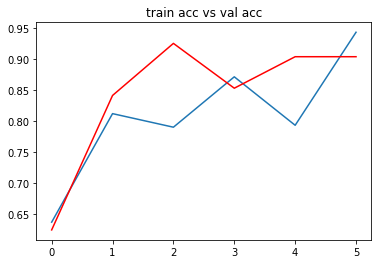

In [27]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')

plt.title('train acc vs val acc')
plt.show()

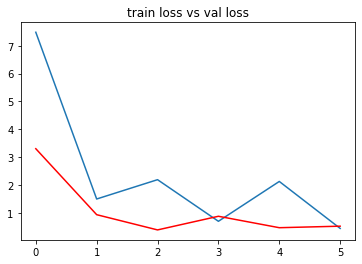

In [28]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')

plt.title('train loss vs val loss')
plt.show()

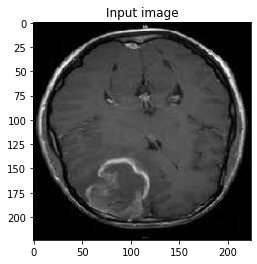

The MRI Scan image is having  Tumor


In [51]:
img_path = '/content/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1066).jpg'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
pred = model.predict(img_preprocessed)
pred = pred*100
plt.imshow(img)
plt.title('Input image')
plt.show()

if pred<95:
    print("The MRI Scan image is having  Tumor")
else:
    print("The MRI Scan image is not having  Tumor")

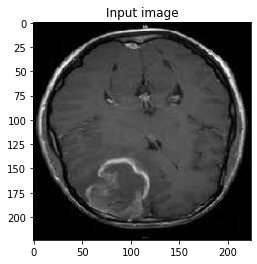

The MRI Scan image is having  Tumor


In [53]:
img_path = '/content/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1066).jpg'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
pred = model.predict(img_preprocessed)
pred = pred*100
plt.imshow(img)
plt.title('Input image')
plt.show()

if pred>=95:
    print("The MRI Scan image is not having  Tumor")
else:
    print("The MRI Scan image is not having  Tumor")